In [1]:
from tokenize import tokenize

from datasets import load_dataset
from transformers import XLMRobertaTokenizerFast
from torch.nn import CrossEntropyLoss
import torch
from transformers import XLMRobertaModel
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader

In [2]:
# if trained on GPU of kaggle, then the following code is needed
!pip install conllu

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Load the dataset, tokenize and check

In [3]:
# load the dataset and tokenizer
dataset = load_dataset("universal_dependencies", "de_gsd")
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

README.md:   0%|          | 0.00/191k [00:00<?, ?B/s]

universal_dependencies.py:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

The repository for universal_dependencies contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/universal_dependencies.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/13814 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/799 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/977 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [4]:
print(f"Number of sentences in the training set: {len(dataset['train'])}")
print(f"Number of sentences in the validation set: {len(dataset['validation'])}")
print(f"Number of sentences in the test set: {len(dataset['test'])}")

Number of sentences in the training set: 13814
Number of sentences in the validation set: 799
Number of sentences in the test set: 977


In [5]:
# total number of unique POS tags
set_upos = set()
for i in range(len(dataset['train'])):
    set_upos.update(dataset["train"][i]["upos"])
for i in range(len(dataset['validation'])):
    set_upos.update(dataset["validation"][i]["upos"])
for i in range(len(dataset['test'])):
    set_upos.update(dataset["test"][i]["upos"])
print(f"Total number of unique POS tags: {len(set_upos)}")

Total number of unique POS tags: 18


In [6]:
# dataset
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

In [7]:
def tokenize_and_align_labels(examples, tokenizer = tokenizer, label_all_tokens=False, skip_index=-100):
    # the max length is close to 200, so set max_length to 200
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding='max_length', max_length=200) 
    labels = []
    
    for i, label in enumerate(examples["upos"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids : list[int] = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(skip_index)

            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])

            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else skip_index)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
# first 5 examples
tokenize_dataset_test = tokenize_and_align_labels(train_dataset[:5])

In [9]:
tokenized_sentences = tokenizer.batch_decode(tokenize_dataset_test['input_ids'], skip_special_tokens=False)

In [10]:
# print the first 5 examples and compare
id2pos = dataset["train"].features["upos"].feature.int2str

for i in range(5):
    # list to string
    origin_text  = ' '.join(dataset['train'][i]['tokens'])
    origin_label = dataset['train'][i]['upos']
    
    # after tokenize and align labels
    tokenized_sentence = tokenized_sentences[i]
    aligned_labels = tokenize_dataset_test['labels'][i]
    
    print(f"=== Sentence {i + 1} ===")
    # this is the original sentence
    print(f"Original Sentence: {origin_text}")
    # this is the tokenized sentence
    print(f"Tokenized Sentence: {tokenized_sentence}")

    # this is the tokenized tokens back to the original tokens
    tokenized_tokens = tokenizer.convert_ids_to_tokens(tokenize_dataset_test["input_ids"][i])
    print(f"Tokenized tokens: {tokenized_tokens}")
    # this is the original POS tags
    print(f"Original POS Tags: {[id2pos(label) for label in origin_label]}")
    
    #len
    print(f"Original POS Tags: {len(origin_label)}")
    print(f"Aligned POS Tags: {[id2pos(label) if label != -100 else 'IGNORED' for label in aligned_labels]}")
    #len
    print(f"Aligned POS Tags: {len(aligned_labels)}")
    print(f"Aligned labels: {aligned_labels}")   
    print(f"Length of aligned labels: {len(aligned_labels)}")
    
    print("\n")

=== Sentence 1 ===
Original Sentence: Sehr gute Beratung , schnelle Behebung der Probleme , so stelle ich mir Kundenservice vor .
Tokenized Sentence: <s> Sehr gute Beratung , schnelle Behebung der Probleme , so stelle ich mir Kundenservice vor .</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [11]:
# given function
def tokenize_and_align_labels(examples, tokenizer, label_all_tokens=False, skip_index=-100):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        # padding to the max length
        padding="max_length",
        # set the max_length to 200 because the max length of the sentence is close to 200
        max_length=200
    )
    labels = []

    for i, label in enumerate(examples["upos"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids: list[int] = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(skip_index)

            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])

            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else skip_index)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [12]:
# map train_dataset, val_dataset, test_dataset
train_dataset = train_dataset.map(lambda examples: tokenize_and_align_labels(examples, tokenizer), batched=True)
val_dataset = val_dataset.map(lambda examples: tokenize_and_align_labels(examples, tokenizer), batched=True)
test_dataset = test_dataset.map(lambda examples: tokenize_and_align_labels(examples, tokenizer), batched=True)

# set the format to Pytorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# create the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

next(iter(train_dataloader))

Map:   0%|          | 0/13814 [00:00<?, ? examples/s]

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/977 [00:00<?, ? examples/s]

{'input_ids': tensor([[     0,  93404,  25989,  ...,      1,      1,      1],
         [     0,    622,  30882,  ...,      1,      1,      1],
         [     0,  43268,     13,  ...,      1,      1,      1],
         ...,
         [     0,  43268,      6,  ...,      1,      1,      1],
         [     0,    563, 109833,  ...,      1,      1,      1],
         [     0,  35302,   1649,  ...,      1,      1,      1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[-100,   14,    6,  ..., -100, -100, -100],
         [-100,    8,    0,  ..., -100, -100, -100],
         [-100,    6, -100,  ..., -100, -100, -100],
         ...,
         [-100,    6,    1,  ..., -100, -100, -100],
         [-100,   16, -100,  ..., -100, -100, -100],
         [-100,    7,   14,  ..., -100, -100, -1

In [13]:
# check the shape of the input_ids and labels
for batch in train_dataloader:
    print("Input IDs shape:", batch["input_ids"].shape)  
    print("Labels shape:", batch["labels"].shape)        
    break


Input IDs shape: torch.Size([32, 200])
Labels shape: torch.Size([32, 200])


# Define the model

In [14]:
# get 
xlmrmodel = XLMRobertaModel.from_pretrained("xlm-roberta-base")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [15]:
import torch.nn as nn
# define the model
class POS_tag(nn.Module):
    def __init__(self, freeze_roberta_part = False):
        super().__init__()
        self.main_part = xlmrmodel
        # freeze the RoBERTa part
        if freeze_roberta_part:
            for param in self.main_part.parameters():
                param.requires_grad = False

        self.added_classifier = nn.Linear(self.main_part.config.hidden_size, len(set_upos))

    
    def forward(self, input_ids, attention_mask):
        outputs = self.main_part(input_ids = input_ids, attention_mask = attention_mask)
        last_hidden_state = outputs.last_hidden_state
        logits = self.added_classifier(last_hidden_state)
        return logits
        

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tag_model = POS_tag(freeze_roberta_part=False)
tag_model.to(device)

loss_function = CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(tag_model.parameters(), lr=3e-5, weight_decay=0.008)

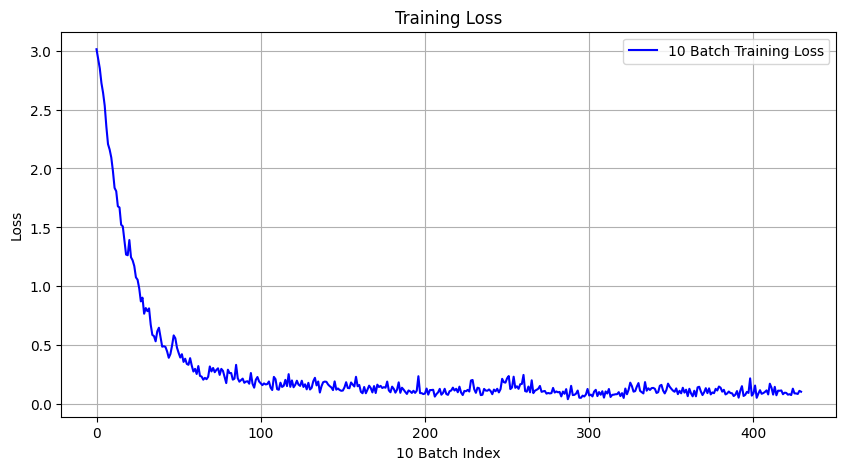

Batch 431 Loss: 0.0877
Batch 432 Loss: 0.0762


In [17]:
# on my computer, in around 100-200 batches, accuracy goes beyond 0.94, and it takes 15min
def train_and_val(model, train_dataloader, val_dataloader, optimizer, loss_function, device, NUM_EPOCHS=4):

    model.train()
    # to keep track of the training loss
    train_losses = []
    # to keep track of the accuracy
    accuracy_list = []

    # loop through the epochs
    for epoch in range(NUM_EPOCHS):
        # training
        # batch_idx to keep track of the batch number
        batch_idx = 0
        for batch in train_dataloader:
            # move the input data to the device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            gold_outputs = batch["labels"].to(device)
            
            # foward pass
            predicted_logits = model(input_ids, attention_mask)
            
            # reshape the predicted_logits and gold_outputs
            predicted_logits = predicted_logits.view(-1, predicted_logits.size(-1))
            gold_outputs = gold_outputs.view(-1)
            # calculate the loss
            batch_loss = loss_function(predicted_logits, gold_outputs)
            # document the loss
            train_losses.append(batch_loss.item())
            # batch_idx to keep track of the batch number
            batch_idx += 1
            print(f"Batch {batch_idx} Loss: {batch_loss.item():.4f}")
            # backpropagation
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            
            # test model on validation set after every 100 batches
            if batch_idx % 100 == 0:
                model.eval()  
                # tokens of not -100
                total_tokens = 0  
                # correct predictions
                correct_predictions = 0 
                
                with torch.no_grad():
                    # batch also 32, as in the train_dataloader
                    for val_batch in val_dataloader:
                        #  input data to the device
                        val_input_ids = val_batch["input_ids"].to(device)
                        val_attention_mask = val_batch["attention_mask"].to(device)
                        val_gold_outputs = val_batch["labels"].to(device)
            
                        # forward pass
                        val_predicted_logits = model(val_input_ids, val_attention_mask)
            
                        # shape adjustment
                        val_predicted_logits = val_predicted_logits.view(-1, val_predicted_logits.size(-1))  # (total_tokens, num_labels)
                        val_gold_outputs = val_gold_outputs.view(-1)  # (total_tokens,)
            
                        # ignore padding token (-100)
                        valid_mask = val_gold_outputs != -100 
            
                        # get the prediction result with the highest probability
                        max_probability_labels = torch.argmax(val_predicted_logits, dim=-1) 
            
                        # get the number of correct predictions
                        correct_predictions += (max_probability_labels[valid_mask] == val_gold_outputs[valid_mask]).sum().item()
                        total_tokens += valid_mask.sum().item()
            
                # calculate the accuracy
                accuracy = correct_predictions / total_tokens
                accuracy_list.append(accuracy)
                print(f"Accuracy: {accuracy:.4f}")
                # back to training mode
                model.train()

        # early stop if needed
        #         if accuracy > 0.94:
        #             return train_losses, accuracy_list

            # plot the training loss every 10 batches
            if batch_idx > 0 and batch_idx % 10 ==0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                plt.plot(train_losses, label="10 Batch Training Loss", color = "blue")
                plt.xlabel("10 Batch Index")
                plt.ylabel("Loss")
                plt.title("Training Loss")
                plt.legend()
                plt.grid(True)
                plt.show()

    return train_losses, accuracy_list

# losses of the training set and accuracy of the validation set
train_losses, accuracy_list = train_and_val(tag_model, train_dataloader, val_dataloader, optimizer, loss_function, device, NUM_EPOCHS=1)

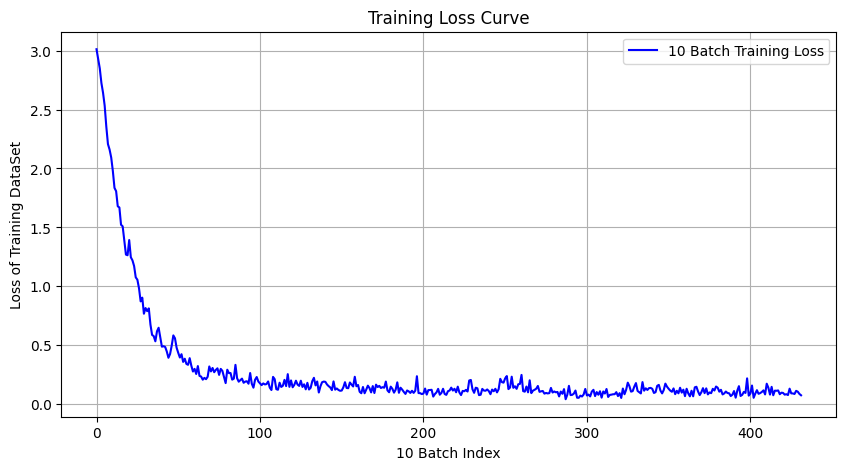

In [18]:
# plot the training loss again out of the function, in case IPython cannot work in some cases: on kaggle it works, on my pc pycharm it does not work
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="10 Batch Training Loss", color = "blue")
plt.xlabel("10 Batch Index")
plt.ylabel("Loss of Training DataSet")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

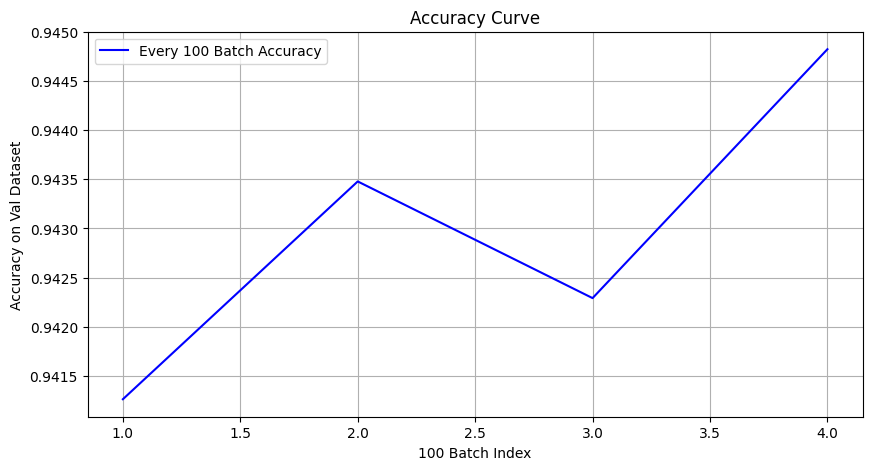

In [24]:
x_values = range(1, len(accuracy_list) + 1)

# plot
plt.figure(figsize=(10, 5))
plt.plot(x_values, accuracy_list, label="Every 100 Batch Accuracy", color="blue")
plt.xlabel("100 Batch Index")
plt.ylabel("Accuracy on Val Dataset")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# on my pc, around 40s
# final model accuracy on the test set
def accuracy(model, test_dataloader, device="cuda"):
    model.to(device)
    model.eval() 
    total_tokens = 0 
    correct_predictions = 0 

    with torch.no_grad():
        for test_batch in test_dataloader:
            # move the input data to the device
            test_input_ids = test_batch["input_ids"].to(device)
            test_attention_mask = test_batch["attention_mask"].to(device)
            test_gold_outputs = test_batch["labels"].to(device)

            # Forward pass
            test_predicted_logits = model(test_input_ids, test_attention_mask)

            # Reshape the predicted_logits and gold_outputs
            test_predicted_logits = test_predicted_logits.view(-1, test_predicted_logits.size(-1))  # (total_tokens, num_labels)
            test_gold_outputs = test_gold_outputs.view(-1) 

            # ignore padding token (-100)
            valid_mask = test_gold_outputs != -100 

            # largest probability
            max_probability_labels = torch.argmax(test_predicted_logits, dim=-1)  # (total_tokens,)

            # number of correct predictions
            correct_predictions += (max_probability_labels[valid_mask] == test_gold_outputs[valid_mask]).sum().item()
            total_tokens += valid_mask.sum().item()

    # calculate the accuracy
    accuracy = correct_predictions / total_tokens
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy
accuracy(tag_model, test_dataloader, device="cuda")

Accuracy: 0.9462


0.9461602671118531

# Compare HMM and Neural POS tagging
Actually, based on my experiments on kaggle, with hyperparameters of AdamW 1r=1e-4, weight_decay=0.01, only after about 200 batches which is less than an epoch, the model trained can get accuracy beyond 0.95 sometimes. That means the model converge really fast within minutes on a GPU that is not expensive. With early stop, actually we can get accuracy beyond 0.94 in several minutes.       
HMM accuracy is about 0.90, and the model is about 0.95, so the model is better than HMM.    
Another advantage of the model is that it can be easily adapted to other languages and tasks, with different layers added or changed.       
Also, the model runs really fast.